In [2]:
import torch
from bit_dataset import BitStringDataset
import lovely_tensors as lt
import wandb
import tqdm
from einops import rearrange, reduce, repeat
from models import (SupervenientFeatureNetwork,
                    CLUB,
                    DecoupledSmileMIEstimator,
                    DownwardSmileMIEstimator,
                    GeneralSmileMIEstimator,
                    SkipConnectionSupervenientFeatureNetwork
                    )
lt.monkey_patch()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()


In [3]:
def train_feature_network(config, trainloader, feature_network):

    wandb.init(project="bits-dataset-neurips", config=config)
    # init weights to zero of the feature network

    decoupled_MI_estimator = DecoupledSmileMIEstimator(
        feature_size=config['feature_size'],
        critic_output_size=config['critic_output_size'],
        hidden_sizes_1=config['decoupled_critic_hidden_sizes_1'],
        hidden_sizes_2=config['decoupled_critic_hidden_sizes_2'],
        clip=config['clip'],
        include_bias=config['bias']
        ).to(device)
    downward_MI_estimators = [
        DownwardSmileMIEstimator(
            feature_size=config['feature_size'],
            critic_output_size=config['critic_output_size'],
            hidden_sizes_v_critic=config['downward_hidden_sizes_v_critic'],
            hidden_sizes_xi_critic=config['downward_hidden_sizes_xi_critic'],
            clip=config['clip'],
            include_bias=config['bias']
            ).to(device) 
        for _ in range(config['num_atoms'])
    ]
    xor_estimator = GeneralSmileMIEstimator(
        x_dim=config['feature_size'],
        y_dim=1,
        critic_output_size=config['critic_output_size'],
        x_critics_hidden_sizes=[512, 512, 128],
        y_critics_hidden_sizes=[512, 512, 128],
        clip=config['clip'],
        include_bias=config['bias']
    ).to(device)

    extra_bit_estimator = GeneralSmileMIEstimator(
        x_dim=config['feature_size'],
        y_dim=1,
        critic_output_size=config['critic_output_size'],
        x_critics_hidden_sizes=[512, 512, 128],
        y_critics_hidden_sizes=[512, 512, 128],
        clip=config['clip'],
        include_bias=config['bias']
    ).to(device)

    bonus_bit_estimator = GeneralSmileMIEstimator(
        x_dim=config['feature_size'],
        y_dim=1,
        critic_output_size=config['critic_output_size'],
        x_critics_hidden_sizes=[512, 512, 128],
        y_critics_hidden_sizes=[512, 512, 128],
        clip=config['clip'],
        include_bias=config['bias']
    ).to(device)

    

    feature_optimizer = torch.optim.Adam(
        feature_network.parameters(),
        lr=config["feature_lr"],
        weight_decay=config["weight_decay"]
    )
    decoupled_optimizer = torch.optim.Adam(
        decoupled_MI_estimator.parameters(),
        lr=config["decoupled_critic_lr"],
        weight_decay=config["weight_decay"]
    )
    downward_optims = [
        torch.optim.Adam(
            dc.parameters(),
            lr=config["downward_lr"],
            weight_decay=config["weight_decay"]
        ) 
        for dc in downward_MI_estimators
    ]
    xor_optimizer = torch.optim.Adam(
        xor_estimator.parameters(),
        lr=1e-3,
        weight_decay=config["weight_decay"]
    )

    extra_bit_optimizer = torch.optim.Adam(
        extra_bit_estimator.parameters(),
        lr=1e-3,
        weight_decay=config["weight_decay"]
    )

    bonus_bit_optimizer = torch.optim.Adam(
        bonus_bit_estimator.parameters(),
        lr=1e-3,
        weight_decay=config["weight_decay"]
    )



    # TODO: figure out why only f network is being watched, I would like to keep a closer eye on the grad n params.
    # TODO: Look at how GANs are trained with pytorch and make sure I'm not doing anything unreasonable.
    # Eg, https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py 
    # ^ this does not require retain_graph=True, so maybe this can be optomized somehow
    wandb.watch(feature_network, log='all')
    wandb.watch(decoupled_MI_estimator, log="all")
    for dc in downward_MI_estimators:
        wandb.watch(dc, log='all')

    ##
    ## TRAIN FEATURE NETWORK
    ##

    epochs = config['epochs']

    for _ in tqdm.tqdm(range(epochs), desc='Training'):
        for batch_num, batch in enumerate(trainloader):
            x0 = batch[:, 0].to(device).float()
            x1 = batch[:, 1].to(device).float()
            v0 = feature_network(x0).detach()
            v1 = feature_network(x1).detach()

            # update decoupled critic
            decoupled_optimizer.zero_grad()
            decoupled_MI = decoupled_MI_estimator(v0, v1)
            decoupled_loss = -decoupled_MI
            decoupled_loss.backward(retain_graph=True)
            decoupled_optimizer.step()

            # update each downward critic 
            for i in range(config['num_atoms']):
                downward_optims[i].zero_grad()
                channel_i = x0[:, i].unsqueeze(1).detach()
                downward_MI_i = downward_MI_estimators[i](v1, channel_i)
                downward_loss = - downward_MI_i
                downward_loss.backward(retain_graph=True)
                downward_optims[i].step()
                # wandb.log({
                #     f"downward_MI_{i}": downward_MI_i   
                # })

            # update feature network   
            feature_optimizer.zero_grad()
            channel_MIs = []

            # MIs = []
            v0 = feature_network(x0)
            v1 = feature_network(x1)

            for i in range(config['num_atoms']):
                channel_i = x0[:, i].unsqueeze(1)
                channel_i_MI = downward_MI_estimators[i](v1, channel_i)
                channel_MIs.append(channel_i_MI)
                # MIs.append(channel_i_MI)

            sum_downward_MI = sum(channel_MIs)

            decoupled_MI1 = decoupled_MI_estimator(v0, v1)

            #clipped_min_MIs = max(0, min(MIs))

            Psi = decoupled_MI1 - sum_downward_MI #+ (config['num_atoms'] - 1) * clipped_min_MIs
            feature_loss = -Psi
            if config['start_updating_f_after'] < batch_num:
                if batch_num % config['update_f_every_N_steps'] == 0:
                    feature_loss.backward(retain_graph=True)
                    feature_optimizer.step()

            wandb.log({
                "decoupled_MI": decoupled_MI1,
                "sum_downward_MI": sum_downward_MI,
                "Psi": Psi,
            })




            v0 = feature_network(x0).detach()
            v1 = feature_network(x1).detach()
            xor_bits = (reduce(x0[: , :5], 'b n -> b', 'sum') % 2).unsqueeze(1)
            extra_bit = x0[:, -1].unsqueeze(1)
            bonus_bit = ( xor_bits + extra_bit ) % 2


            xor_optimizer.zero_grad()
            xor_MI = xor_estimator(v0, xor_bits)
            xor_loss = -xor_MI
            xor_loss.backward(retain_graph=True)
            xor_optimizer.step()

            extra_bit_optimizer.zero_grad()
            extra_bit_MI = extra_bit_estimator(v0, extra_bit)
            extra_bit_loss = -extra_bit_MI
            extra_bit_loss.backward(retain_graph=True)
            extra_bit_optimizer.step()

            bonus_bit_optimizer.zero_grad()
            bonus_bit_MI = bonus_bit_estimator(v0, bonus_bit)
            bonus_bit_loss = -bonus_bit_MI
            bonus_bit_loss.backward(retain_graph=True)
            bonus_bit_optimizer.step()

            wandb.log({
                "xor_MI": xor_MI,
                "extra_bit_MI": extra_bit_MI,
                "bonus_bit_MI": bonus_bit_MI
            })



        
    torch.save(feature_network.state_dict(), f"models/feature_network_{wandb.run.name}.pth")
    
    return feature_network



In [9]:
config = {
    "num_data_points": int(1e6),
    "extra_bit_correlation": 0.99,
    "parity_bit_correlation": 0.99,
    "epochs": 10,
    "batch_size": 1000,
    "num_atoms": 6,
    "feature_size": 1,
    "clip": 5,
    "critic_output_size": 32,
    "downward_hidden_sizes_v_critic": [512, 512, 512, 256],
    "downward_hidden_sizes_xi_critic": [512, 512, 512, 256],
    "feature_hidden_sizes": [256, 256, 256],
    "decoupled_critic_hidden_sizes_1": [512, 512, 512],
    "decoupled_critic_hidden_sizes_2": [512, 512, 512],
    "feature_lr": 1e-5,
    "decoupled_critic_lr": 1e-3,
    "downward_lr": 1e-4,    
    "bias": True,
    "update_f_every_N_steps": 5,
    "weight_decay": 0,
    "start_updating_f_after": 0,
}


In [5]:

torch.manual_seed(42)

dataset = BitStringDataset(
    gamma_parity=config['parity_bit_correlation'],
    gamma_extra=config['extra_bit_correlation'],
    length=config['num_data_points'],
)

trainloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=config['batch_size'],
    shuffle=True,
)




In [6]:

# feature_network = SkipConnectionSupervenientFeatureNetwork(
#     num_atoms=config['num_atoms'],
#     feature_size=config['feature_size'],
#     hidden_sizes=config['feature_hidden_sizes'],
#     include_bias=config['bias']
#     ).to(device)


# feature_network = SupervenientFeatureNetwork(
#     num_atoms=config['num_atoms'],
#     feature_size=config['feature_size'],
#     hidden_sizes=config['feature_hidden_sizes'],
#     include_bias=config['bias']
#     ).to(device)


In [10]:
# load /Users/davidmcsharry/dev/imperial/info-theory-experiments/models/feature_network_old-cantina-33.pth



feature_network = SkipConnectionSupervenientFeatureNetwork(
    num_atoms=config['num_atoms'],
    feature_size=config['feature_size'],
    hidden_sizes=config['feature_hidden_sizes'],
    include_bias=config['bias']
    ).to(device)

# load /vol/bitbucket/dm2223/info-theory-experiments/models/feature_network_old-podracer-43.pth

feature_network.load_state_dict(torch.load("/vol/bitbucket/dm2223/info-theory-experiments/models/feature_network_old-podracer-43.pth"))


feature_network = train_feature_network(config, trainloader, feature_network)

Psi,▅▂▃▁▃▅▆▆▅▆▆▆▆▆▆▆▆▆▅▅▅▅▄▃▆▅▄▃▂▅▃▃█▄▅▇▅▆▅▅
bonus_bit_MI,▆▆▆▆▇▆▆▆▇▇▇▇▇▇█▇▇▇█▇▁███▆▆▆▆█▇▇▆▇▆▇▆▆▇▆▇
decoupled_MI,▁▃█▃▅▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
extra_bit_MI,▅▆▇██▁▂▂▂▁▂▃▃▁▁▂▁▁▁▂▂▂▂▃▁▂▂▃▅▄▅▅▃▃▃▃▂▁▂▂
sum_downward_MI,▄▇▆█▆▄▃▃▄▃▃▃▃▃▃▃▃▃▄▃▄▃▅▆▃▄▅▆▇▄▆▆▁▅▄▂▄▃▄▄
xor_MI,▁▁▂▁▁▂▅▆▆▆▅▅▅▅▆▅▄▇▃▇▇▇██▅▅▆▅▆▆▅▆▄▅▅▅▅▇▇█
Psi,-0.00954
bonus_bit_MI,0.04939
decoupled_MI,3e-05
extra_bit_MI,0.00026
sum_downward_MI,0.00957


Training: 100%|██████████| 10/10 [04:42<00:00, 28.23s/it]


In [ ]:
# make a dataset of every possible bitstring



In [15]:
def find_true_Psi(feature_network, run_id, feature_network_config, trainloader):

    config = {
        "epochs": 1,
        "batch_size": 600,
        "num_atoms": 6,
        "feature_size": feature_network_config['feature_size'],
        "clip": 5,
        "critic_output_size": 16,
        "downward_hidden_sizes_v_critic": [512, 512, 128],
        "downward_hidden_sizes_xi_critic": [512, 512, 128],
        "decoupled_critic_hidden_sizes_1": [512, 512, 128],
        "decoupled_critic_hidden_sizes_2": [512, 512, 128],
        "decoupled_critic_lr": 1e-3,
        "downward_lr": 1e-3,
        "bias": True,
        "weight_decay": 1e-6,
        "original_run_id": run_id
    }

    wandb.init(project="BITS_Finding-true-Psi-for-f", config=config, id=run_id)

    decoupled_critic = DecoupledSmileMIEstimator(
        feature_size=config['feature_size'],
        critic_output_size=config['critic_output_size'],
        hidden_sizes_1=config['decoupled_critic_hidden_sizes_1'],
        hidden_sizes_2=config['decoupled_critic_hidden_sizes_2'],
        clip=config['clip'],
        include_bias=config['bias']
        ).to(device)

    downward_critics = [
        DownwardSmileMIEstimator(
            feature_size=config['feature_size'],
            critic_output_size=config['critic_output_size'],
            hidden_sizes_v_critic=config['downward_hidden_sizes_v_critic'],
            hidden_sizes_xi_critic=config['downward_hidden_sizes_xi_critic'],
            clip=config['clip'],
            include_bias=config['bias']
            ).to(device) 
        for _ in range(config['num_atoms'])
    ]

    xor_estimator = GeneralSmileMIEstimator(
        x_dim=config['feature_size'],
        y_dim=1,
        critic_output_size=config['critic_output_size'],
        x_critics_hidden_sizes=[512, 512, 128],
        y_critics_hidden_sizes=[512, 512, 128],
        clip=config['clip'],
        include_bias=config['bias']
    ).to(device)

    extra_bit_estimator = GeneralSmileMIEstimator(
        x_dim=config['feature_size'],
        y_dim=1,
        critic_output_size=config['critic_output_size'],
        x_critics_hidden_sizes=[512, 512, 128],
        y_critics_hidden_sizes=[512, 512, 128],
        clip=config['clip'],
        include_bias=config['bias']
    ).to(device)

    bonus_bit_estimator = GeneralSmileMIEstimator(
        x_dim=config['feature_size'],
        y_dim=1,
        critic_output_size=config['critic_output_size'],
        x_critics_hidden_sizes=[512, 512, 128],
        y_critics_hidden_sizes=[512, 512, 128],
        clip=config['clip'],
        include_bias=config['bias']
    ).to(device)


    downward_optims = [
        torch.optim.Adam(
            dc.parameters(),
            lr=config["downward_lr"],
            weight_decay=config["weight_decay"]
        ) 
        for dc in downward_critics
    ]

    decoupled_optimizer = torch.optim.Adam(
        decoupled_critic.parameters(),
        lr=config["decoupled_critic_lr"],
        weight_decay=config["weight_decay"]
    )

    xor_optimizer = torch.optim.Adam(
        xor_estimator.parameters(),
        lr=config["decoupled_critic_lr"],
        weight_decay=config["weight_decay"]
    )

    extra_bit_optimizer = torch.optim.Adam(
        extra_bit_estimator.parameters(),
        lr=config["decoupled_critic_lr"],
        weight_decay=config["weight_decay"]
    )

    bonus_bit_optimizer = torch.optim.Adam(
        bonus_bit_estimator.parameters(),
        lr=config["decoupled_critic_lr"],
        weight_decay=config["weight_decay"]
    )


    # TODO: figure out why only f network is being watched, I would like to keep a closer eye on the grad n params.
    # TODO: Look at how GANs are trained with pytorch and make sure I'm not doing anything unreasonable.
    # Eg, https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py 
    # ^ this does not require retain_graph=True, so maybe this can be optomized somehow
    wandb.watch(decoupled_critic, log="all")
    for dc in downward_critics:
        wandb.watch(dc, log='all')

    epochs = config['epochs']

    for _ in tqdm.tqdm(range(epochs), desc='Training'):
        for _, batch in enumerate(trainloader):
            x0 = batch[:, 0].to(device).float()
            x1 = batch[:, 1].to(device).float()

            # update decoupled critic

            v0 = feature_network(x0)
            v1 = feature_network(x1) 

            xor_bits = (reduce(x0[: , :5], 'b n -> b', 'sum') % 2).unsqueeze(1)
            extra_bit = x0[:, -1].unsqueeze(1)
            bonus_bit = ( xor_bits + extra_bit ) % 2


            decoupled_optimizer.zero_grad()
            decoupled_MI = decoupled_critic(v0, v1)
            decoupled_loss = -decoupled_MI
            decoupled_loss.backward(retain_graph=True)
            decoupled_optimizer.step()


            # update each downward critic 

            MIs = []

            for i in range(config['num_atoms']):
                downward_optims[i].zero_grad()
                channel_i = x0[:, i].unsqueeze(1)
                downward_MI_i = downward_critics[i](v1, channel_i)
                # add spectral norm to the loss
                downward_loss = - downward_MI_i
                downward_loss.backward(retain_graph=True)
                downward_optims[i].step()
                # wandb.log({
                #     f"downward_MI_{i}": downward_MI_i   
                # })
                MIs.append(downward_MI_i)

            # update feature network   

            min_MI = min(MIs)
            clipped_min_MIs = max(0, min_MI)

            sum_downward_MI = 0

            for i in range(config['num_atoms']):
                channel_i = x0[:, i].unsqueeze(1)
                sum_downward_MI += downward_critics[i](v1, channel_i)

            decoupled_MI1 = decoupled_critic(v0, v1)

            Psi = decoupled_MI1 - sum_downward_MI + (config['num_atoms'] - 1) * clipped_min_MIs

            wandb.log({
                "decoupled_MI": decoupled_MI1,
                "sum_downward_MI": sum_downward_MI,
                "Psi": Psi,
            })

            xor_optimizer.zero_grad()
            xor_MI = xor_estimator(v0, xor_bits)
            xor_loss = -xor_MI
            xor_loss.backward(retain_graph=True)
            xor_optimizer.step()

            extra_bit_optimizer.zero_grad()
            extra_bit_MI = extra_bit_estimator(v0, extra_bit)
            extra_bit_loss = -extra_bit_MI
            extra_bit_loss.backward(retain_graph=True)
            extra_bit_optimizer.step()

            bonus_bit_optimizer.zero_grad()
            bonus_bit_MI = bonus_bit_estimator(v0, bonus_bit)
            bonus_bit_loss = -bonus_bit_MI
            bonus_bit_loss.backward(retain_graph=True)
            bonus_bit_optimizer.step()

            wandb.log({
                "xor_MI": xor_MI,
                "extra_bit_MI": extra_bit_MI,
                "bonus_bit_MI": bonus_bit_MI
            })
            
        
    return Psi


In [16]:
Psi = find_true_Psi(feature_network, None, config, trainloader)

Training: 100%|██████████| 1/1 [00:28<00:00, 28.51s/it]


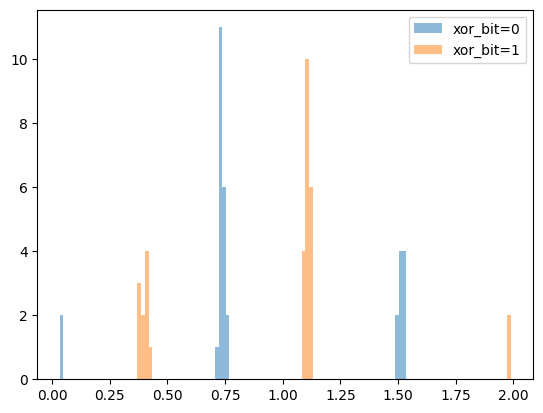

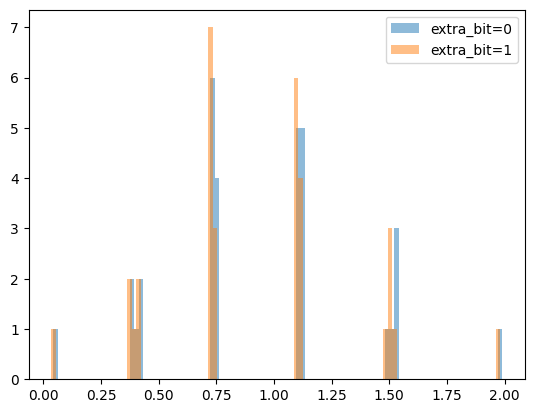

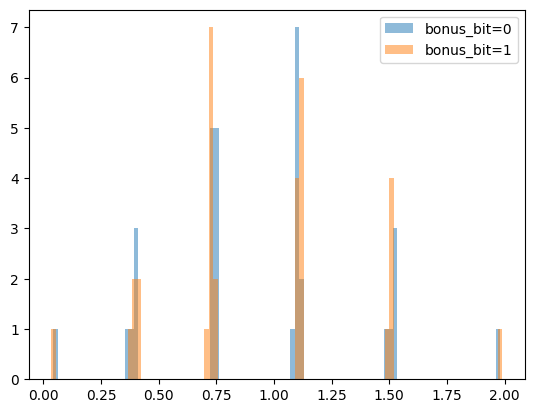

In [21]:

# plot the various values of V to visually inspect if they contain information about the different bits


binary_numbers = torch.tensor([[int(bit) for bit in f"{i:06b}"] for i in range(2**6)])

v = feature_network(binary_numbers.float().to(device))

xor_bits = (reduce(binary_numbers[:, :5], 'b n -> b', 'sum') % 2).unsqueeze(1)

# plot the different values of v on a histogram, with different colors for the two different xor bits

import matplotlib.pyplot as plt
import numpy as np

v_np = v.detach().cpu().numpy()
xor_bits_np = xor_bits.cpu().numpy()

plt.hist(v_np[xor_bits_np == 0], bins=100, alpha=0.5, label='xor_bit=0')
plt.hist(v_np[xor_bits_np == 1], bins=100, alpha=0.5, label='xor_bit=1')
plt.legend()
plt.show()


extra_bits = binary_numbers[:, -1].unsqueeze(1)

# plot the different values of v on a histogram, with different colors for the two different extra bits


plt.hist(v_np[extra_bits == 0], bins=100, alpha=0.5, label='extra_bit=0')
plt.hist(v_np[extra_bits == 1], bins=100, alpha=0.5, label='extra_bit=1')
plt.legend()
plt.show()


bonus_bits = ( xor_bits + extra_bits ) % 2

# plot the different values of v on a histogram, with different colors for the two different bonus bits


plt.hist(v_np[bonus_bits == 0], bins=100, alpha=0.5, label='bonus_bit=0')
plt.hist(v_np[bonus_bits == 1], bins=100, alpha=0.5, label='bonus_bit=1')
plt.legend()
plt.show()



+---------+-------+------------+--------------+
|   Index |    v0 |   xor_bits |   extra_bits |
+=========+=======+============+==============+
|       0 | 1.088 |          1 |            1 |
+---------+-------+------------+--------------+
|       1 | 0.759 |          0 |            0 |
+---------+-------+------------+--------------+
|       2 | 1.121 |          1 |            1 |
+---------+-------+------------+--------------+
|       3 | 0.033 |          0 |            1 |
+---------+-------+------------+--------------+
|       4 | 1.103 |          1 |            0 |
+---------+-------+------------+--------------+
|       5 | 1.098 |          1 |            0 |
+---------+-------+------------+--------------+
|       6 | 0.74  |          0 |            1 |
+---------+-------+------------+--------------+
|       7 | 1.49  |          0 |            1 |
+---------+-------+------------+--------------+
|       8 | 1.511 |          0 |            1 |
+---------+-------+------------+--------

Text(0.5, 0, 'v0')

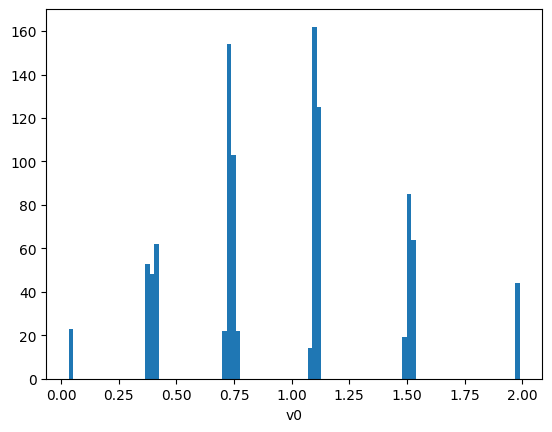

In [12]:

for batch in trainloader:
    x0 = batch[:, 0].to(device).float()
    x1 = batch[:, 1].to(device).float()

    v0 = feature_network(x0).squeeze()
    xor_bits = reduce(x0[: , :5], 'b n -> b', 'sum') % 2
    extra_bits = x0[:, -1]
    
    break


from tabulate import tabulate

# Assuming v0, xor_bits, and extra_bits are already defined as PyTorch tensors

# Convert the tensors to Python lists
v0_list = v0.tolist()
xor_bits_list = xor_bits.tolist()
extra_bits_list = extra_bits.tolist()
# Create a list of lists containing the values at each index
table_data = [[i, round(v0_list[i],3), xor_bits_list[i], extra_bits_list[i]] for i in range(len(v0_list))]
# Define the table headers
headers = ["Index", "v0", "xor_bits", "extra_bits"]
# Print the table using tabulate
print(tabulate(table_data, headers, tablefmt="grid"))


# plot v0_list histogram
import matplotlib.pyplot as plt
plt.hist(v0_list, bins=100)
plt.xlabel('v0')



In [17]:

# find the mutual informatoin between v0 abd v1

critic = GeneralSmileMIEstimator(
    x_dim=config['feature_size'],
    y_dim=config['feature_size'],
    critic_output_size=config['critic_output_size'],
    x_critics_hidden_sizes=[512, 512, 128],
    y_critics_hidden_sizes=[512, 512, 128],
    clip=config['clip'],
    include_bias=config['bias']
).to(device)

critic_optimizer = torch.optim.Adam(
    critic.parameters(),
    lr=config["decoupled_critic_lr"],
    weight_decay=config["weight_decay"]
)

for _ in range(10):
    for batch in trainloader:
        x0 = batch[:, 0].to(device).float()
        x1 = batch[:, 1].to(device).float()

        v0 = feature_network(x0)
        v1 = feature_network(x1)

        critic_optimizer.zero_grad()
        MI = critic(v0, v1)
        loss = -MI
        loss.backward()
        critic_optimizer.step()

        print(MI.item())
        

-3.3736228942871094e-05
-0.00037384033203125
-0.00010228157043457031
-0.00011932849884033203
2.5510787963867188e-05
-2.205371856689453e-05
-2.562999725341797e-05
-1.537799835205078e-05
-0.00010895729064941406
-3.039836883544922e-05
3.5643577575683594e-05
-2.5033950805664062e-06
-2.288818359375e-05
-4.38690185546875e-05
-5.257129669189453e-05
-6.198883056640625e-06
-8.940696716308594e-06
1.1920928955078125e-05
-7.748603820800781e-06
-7.271766662597656e-06
2.086162567138672e-05
1.4543533325195312e-05
8.344650268554688e-06
6.079673767089844e-06
-1.2755393981933594e-05
1.2993812561035156e-05
1.990795135498047e-05
2.396106719970703e-05
2.682209014892578e-05
1.0132789611816406e-05
2.8371810913085938e-05
1.8715858459472656e-05
2.384185791015625e-06
2.1457672119140625e-06
4.982948303222656e-05
0.00011157989501953125
2.5033950805664062e-05
6.270408630371094e-05
0.000213623046875
7.855892181396484e-05
0.00021958351135253906
-3.910064697265625e-05
0.0005066394805908203
9.059906005859375e-05
0.000

KeyboardInterrupt: 

In [18]:
# predict the extra_bit_0 from v0

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(config['feature_size'], 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 1)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

mlp = MLP().to(device)

mlp_optimizer = torch.optim.Adam(
    mlp.parameters(),
    lr=config["decoupled_critic_lr"],
    weight_decay=config["weight_decay"]
)

accuracies = []

import matplotlib.pyplot as plt

for _ in range(1):
    for batch in trainloader:
        x0 = batch[:, 0].to(device).float()
        # x1 = batch[:, 1].to(device).float()

        v0 = feature_network(x0)
        extra_bit_0 = x0[:, -1].unsqueeze(1)

        mlp_optimizer.zero_grad()
        extra_bit_pred = mlp(v0)
        loss = torch.nn.functional.mse_loss(extra_bit_pred, extra_bit_0)
        loss.backward()
        mlp_optimizer.step()

        print(loss.item())

        # accuracy
        correct = (torch.round(extra_bit_pred) == extra_bit_0).sum().item()

        print(correct / len(extra_bit_0))

        accuracies.append(correct / len(extra_bit_0))

plt.plot(accuracies)
plt.xlabel('batch')
plt.ylabel('accuracy')
plt.title('Extra Bit Prediction Accuracy')
plt.show()

0.45978233218193054
0.493
0.3813325762748718
0.488
0.32343071699142456
0.491
0.2814885675907135
0.475
0.2618999779224396
0.445
0.27204078435897827
0.463
0.26957643032073975
0.526
0.2984471917152405
0.469
0.29101037979125977
0.487
0.28738704323768616
0.475
0.27958205342292786
0.47
0.268577516078949
0.493
0.2584816813468933
0.496
0.2494756132364273
0.522
0.25160202383995056
0.49
0.2507638931274414
0.501
0.2519492208957672
0.52
0.25410449504852295
0.511
0.25475552678108215
0.513
0.25493356585502625
0.524
0.2579396665096283
0.48
0.2555769681930542
0.501
0.2513088583946228
0.497
0.24879035353660583
0.519
0.24946945905685425
0.513
0.24739041924476624
0.602
0.24951402842998505
0.56
0.24893411993980408
0.547
0.24959732592105865
0.49
0.24905596673488617
0.489
0.25026583671569824
0.501
0.25021761655807495
0.497
0.25073710083961487
0.514
0.25115710496902466
0.511
0.24980969727039337
0.478
0.252182275056839
0.47
0.24978116154670715
0.497
0.2510982155799866
0.468
0.24892225861549377
0.517
0.2491973

NameError: name 'plt' is not defined

In [19]:
# predict the xor_bit_0 from v0

mlp = MLP().to(device)

mlp_optimizer = torch.optim.Adam(
    mlp.parameters(),
    lr=config["decoupled_critic_lr"],
    weight_decay=config["weight_decay"]
)
for _ in range(5):
    for batch in trainloader:
        x0 = batch[:, 0].to(device).float()
        x1 = batch[:, 1].to(device).float()

        v0 = feature_network(x0)
        xor_bits = (reduce(x0[: , :5], 'b n -> b', 'sum') % 2).unsqueeze(1)

        mlp_optimizer.zero_grad()
        xor_bits_pred = mlp(v0)
        loss = torch.nn.functional.mse_loss(xor_bits_pred, xor_bits)
        loss.backward()
        mlp_optimizer.step()

        print(loss.item())

        # accuracy
        correct = (torch.round(xor_bits_pred) == xor_bits).sum().item()

        print(correct / len(xor_bits))

0.4968370199203491
0.499
0.39868658781051636
0.488
0.31688255071640015
0.501
0.281648188829422
0.471
0.2520827353000641
0.46
0.24911853671073914
0.568
0.2528301477432251
0.521
0.2635434865951538
0.52
0.28625553846359253
0.478
0.28395700454711914
0.502
0.27838215231895447
0.501
0.26811137795448303
0.5
0.26547884941101074
0.482
0.25353047251701355
0.506
0.2494342029094696
0.487
0.24339203536510468
0.502
0.24159866571426392
0.661
0.24259747564792633
0.631
0.24120527505874634
0.508
0.2425321638584137
0.54
0.24430523812770844
0.532
0.2506183385848999
0.501
0.2463686764240265
0.517
0.24302566051483154
0.525
0.24270732700824738
0.512
0.23529547452926636
0.555
0.23633620142936707
0.534
0.2342764437198639
0.567
0.2321450114250183
0.646
0.23108601570129395
0.913
0.23218487203121185
0.815
0.23278185725212097
0.482
0.2319032996892929
0.486
0.23140209913253784
0.488
0.23025891184806824
0.481
0.22757667303085327
0.491
0.22541670501232147
0.895
0.22535522282123566
0.968
0.22402004897594452
0.964
0.22

KeyboardInterrupt: 

In [20]:
# find the mutual informatoin between v1 and xor_bits_1

critic = GeneralSmileMIEstimator(
    x_dim=config['feature_size'],
    y_dim=1,
    critic_output_size=config['critic_output_size'],
    x_critics_hidden_sizes=[1024, 1024, 1024, 512],
    y_critics_hidden_sizes=[1024, 1024, 1024, 512],
    clip=config['clip'],
    include_bias=config['bias']
).to(device)

critic_optimizer = torch.optim.Adam(
    critic.parameters(),
    lr=config["decoupled_critic_lr"],
    weight_decay=config["weight_decay"]
)


for batch in trainloader:
    # x0 = batch[:, 0].to(device).float()
    x1 = batch[:, 1].to(device).float()

    v1 = feature_network(x1)
    xor_bits_1 = (reduce(x1[: , :5], 'b n -> b', 'sum') % 2).unsqueeze(1)

    critic_optimizer.zero_grad()
    MI = critic(v1, xor_bits_1)
    loss = -MI
    loss.backward()
    critic_optimizer.step()

    print(MI.item())



1.8358230590820312e-05
-0.0005812644958496094
-0.0005776882171630859
-0.00015282630920410156
8.082389831542969e-05
5.412101745605469e-05
3.2901763916015625e-05
7.915496826171875e-05
5.614757537841797e-05
9.310245513916016e-05
0.0002117156982421875
0.0003572702407836914
0.0006357431411743164
0.0013953447341918945
0.00309145450592041
0.006243586540222168
0.014219284057617188
0.03043842315673828
0.03705394268035889
0.029929757118225098
0.08572876453399658
0.0434267520904541
0.1259756088256836
0.1196446418762207
0.21522307395935059
0.15838384628295898
0.2684434652328491
0.35697436332702637
0.26956701278686523
-0.11143553256988525
0.3917888402938843
0.20189273357391357
0.41757214069366455
0.3496513366699219
0.3087799549102783
0.4218240976333618
0.4878641366958618
0.4002711772918701
0.5505049228668213
0.2571072578430176
0.6134289503097534
0.43392646312713623
0.5748457908630371
0.5697944164276123
0.6058764457702637
0.5989366769790649
0.6480770111083984
0.6065632104873657
0.6473993062973022
0.

KeyboardInterrupt: 

In [21]:
# predict extra_bit_1 from v1

mlp = MLP().to(device)

mlp_optimizer = torch.optim.Adam(
    mlp.parameters(),
    lr=config["decoupled_critic_lr"],
    weight_decay=config["weight_decay"]
)

for _ in range(5):
    for batch in trainloader:
        x0 = batch[:, 0].to(device).float()
        x1 = batch[:, 1].to(device).float()

        v1 = feature_network(x1)
        extra_bit_1 = x1[:, -1].unsqueeze(1)

        mlp_optimizer.zero_grad()
        extra_bit_pred = mlp(v1)
        loss = torch.nn.functional.mse_loss(extra_bit_pred, extra_bit_1)
        loss.backward()
        mlp_optimizer.step()

        print(loss.item())

        # accuracy
        correct = (torch.round(extra_bit_pred) == extra_bit_1).sum().item()

        print(correct / len(extra_bit_1))

0.5265204906463623
0.482
0.3928671181201935
0.515
0.3341712951660156
0.497
0.2994028329849243
0.47
0.27655479311943054
0.41
0.28312984108924866
0.473
0.28131160140037537
0.509
0.30024999380111694
0.503
0.3030056357383728
0.498
0.2945246398448944
0.486
0.27660757303237915
0.52
0.264733225107193
0.531
0.26292529702186584
0.494
0.25460100173950195
0.568
0.252375990152359
0.501
0.25296393036842346
0.436
0.25279638171195984
0.514
0.25454646348953247
0.535
0.2602475881576538
0.543
0.2589772641658783
0.526
0.257387638092041
0.525
0.2541559934616089
0.528
0.25576019287109375
0.501
0.25364407896995544
0.499
0.2527614235877991
0.502
0.2523396611213684
0.567
0.2503519058227539
0.528
0.252482533454895
0.524
0.25165021419525146
0.495
0.25252872705459595
0.507
0.2474178671836853
0.509
0.25069713592529297
0.508
0.2510756552219391
0.509
0.2517884075641632
0.499
0.24917885661125183
0.496
0.2490101456642151
0.536
0.2500148117542267
0.539
0.2487490475177765
0.571
0.2475930005311966
0.575
0.24716268479824

KeyboardInterrupt: 

In [22]:
# predict the bonus bit from v0

mlp = MLP().to(device)

mlp_optimizer = torch.optim.Adam(
    mlp.parameters(),
    lr=config["decoupled_critic_lr"],
    weight_decay=config["weight_decay"]
)
for _ in range(3):
    for batch in trainloader:
        x0 = batch[:, 0].to(device).float()
        x1 = batch[:, 1].to(device).float()

        v0 = feature_network(x0)
        xor_bits = (reduce(x0[: , :5], 'b n -> b', 'sum') % 2).unsqueeze(1)
        extra_bit = x0[:, -1].unsqueeze(1)
        bonus_bit = ( xor_bits + extra_bit ) % 2

        mlp_optimizer.zero_grad()
        bonus_bit_pred = mlp(v0)
        loss = torch.nn.functional.mse_loss(bonus_bit_pred, bonus_bit)
        loss.backward()
        mlp_optimizer.step()

        print(loss.item())

        # accuracy
        correct = (torch.round(bonus_bit_pred) == bonus_bit).sum().item()

        print(correct / len(bonus_bit))


0.49696841835975647
0.507
0.42108848690986633
0.483
0.32824715971946716
0.513
0.2781296670436859
0.522
0.25469735264778137
0.517
0.24948017299175262
0.535
0.25879666209220886
0.485
0.2674776315689087
0.506
0.28426414728164673
0.482
0.2848300337791443
0.503
0.2811897397041321
0.503
0.2790883183479309
0.495
0.25805577635765076
0.541
0.26950761675834656
0.483
0.2613646388053894
0.476
0.2512360215187073
0.516
0.2525939345359802
0.532
0.2495993822813034
0.533
0.2501431703567505
0.504
0.25161537528038025
0.506
0.2514081597328186
0.524
0.2563420832157135
0.494
0.25375592708587646
0.516
0.2562248110771179
0.502
0.2557264268398285
0.503
0.2514399588108063
0.521
0.2544398903846741
0.502
0.2514389753341675
0.502
0.25230056047439575
0.481
0.24814370274543762
0.508
0.24910083413124084
0.548
0.24765273928642273
0.508
0.24937286972999573
0.582
0.2510209083557129
0.469
0.2504943311214447
0.486
0.2523019015789032
0.471
0.2474128007888794
0.509
0.24931395053863525
0.493
0.24638792872428894
0.515
0.24894

KeyboardInterrupt: 

In [27]:
# find the mutual information between extra bit and xor bit

critic = GeneralSmileMIEstimator(
    x_dim=1,
    y_dim=1,
    critic_output_size=config['critic_output_size'],
    x_critics_hidden_sizes=[1024, 1024, 1024, 512],
    y_critics_hidden_sizes=[1024, 1024, 1024, 512],
    clip=config['clip'],
    include_bias=config['bias']
).to(device)

critic_optimizer = torch.optim.Adam(
    critic.parameters(),
    lr=config["decoupled_critic_lr"],
    weight_decay=config["weight_decay"]
)

for _ in range(3):
    for batch in trainloader:
        x0 = batch[:, 0].to(device).float()
        x1 = batch[:, 1].to(device).float()

        xor_bits = (reduce(x0[: , :5], 'b n -> b', 'sum') % 2).unsqueeze(1)
        extra_bit = x0[:, -1].unsqueeze(1)

        critic_optimizer.zero_grad()
        MI = critic(xor_bits, extra_bit)
        loss = -MI
        loss.backward()
        critic_optimizer.step()

        print(MI.item())

2.1457672119140625e-06
-0.0018481016159057617
-0.002142667770385742
0.0
7.3909759521484375e-06
-2.1457672119140625e-06
1.6689300537109375e-06
6.198883056640625e-06
-7.62939453125e-06
2.2292137145996094e-05
-6.794929504394531e-06
-9.5367431640625e-07
-1.8835067749023438e-05
4.172325134277344e-06
-5.245208740234375e-06
3.5762786865234375e-07
-1.1920928955078125e-06
-1.1920928955078125e-07
-5.960464477539062e-07
-1.3232231140136719e-05
-4.0531158447265625e-06
4.0531158447265625e-06
4.5299530029296875e-06
5.364418029785156e-06
-3.0994415283203125e-06
-1.0609626770019531e-05
3.266334533691406e-05
-1.4424324035644531e-05
6.079673767089844e-06
2.8848648071289062e-05
-2.1576881408691406e-05
2.288818359375e-05
-2.0742416381835938e-05
2.1696090698242188e-05
5.173683166503906e-05
3.1828880310058594e-05
2.3603439331054688e-05
0.0001081228256225586
7.677078247070312e-05
0.00014889240264892578
-0.002756953239440918
-0.00010883808135986328
1.1682510375976562e-05
5.4836273193359375e-06
-4.649162292480

KeyboardInterrupt: 

In [28]:
# find MI between adjacent XOR bits

critic = GeneralSmileMIEstimator(
    x_dim=1,
    y_dim=1,
    critic_output_size=config['critic_output_size'],
    x_critics_hidden_sizes=[1024, 1024, 1024, 512],
    y_critics_hidden_sizes=[1024, 1024, 1024, 512],
    clip=config['clip'],
    include_bias=config['bias']
).to(device)

critic_optimizer = torch.optim.Adam(
    critic.parameters(),
    lr=config["decoupled_critic_lr"],
    weight_decay=config["weight_decay"]
)

for _ in range(3):
    for batch in trainloader:
        x0 = batch[:, 0].to(device).float()
        x1 = batch[:, 1].to(device).float()

        xor_bit0 = (reduce(x0[: , :5], 'b n -> b', 'sum') % 2).unsqueeze(1)
        xor_bit1 = (reduce(x1[: , :5], 'b n -> b', 'sum') % 2).unsqueeze(1)

        critic_optimizer.zero_grad()
        MI = critic(xor_bit0, xor_bit1)
        loss = -MI
        loss.backward()
        critic_optimizer.step()

        print(MI.item())


-0.00020933151245117188
0.008465409278869629
0.15796005725860596
0.554111123085022
-1.076429843902588
2.2095882892608643
-0.6097109317779541
0.2727820873260498
0.25519561767578125
0.12728846073150635
0.08189165592193604
0.07232928276062012
0.08132362365722656
0.10371828079223633
0.13109242916107178
0.16072797775268555
0.18412983417510986
0.21075069904327393
0.259973406791687
0.36223745346069336
0.4748570919036865
0.5793713331222534
0.612297534942627
0.05643594264984131
0.11494016647338867
0.3965383768081665
0.575911283493042
0.3935638666152954
0.4628719091415405
0.5380468368530273
0.5809950828552246
0.5585695505142212
0.602544903755188
0.6450358629226685
0.626807451248169
0.6149082183837891
0.5831902027130127
0.6329926252365112
0.6320503950119019
0.5952777862548828
0.6269587278366089
0.6039475202560425
0.6267435550689697
0.6547170877456665
0.6395190954208374
0.6233201026916504
0.6631959080696106
0.630669116973877
0.6284555196762085
0.6453116536140442
0.6404870748519897
0.66536331176757

KeyboardInterrupt: 

In [ ]:
# find MI between v0 and extra_bit_0
